In [74]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as tvtransforms
import time
import torch
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import albumentations as A
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

In [75]:
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'ocean', 'wetsand', 'buildings', 'vegetation', 'drysand']
ACTIVATION = None
BATCH_SIZE = 1
DEVICE = 'cuda'
TRAIN_IMG_DIR = "../../CoastSat/data/blackpool/images/train/"
TRAIN_MASK_DIR = "../../CoastSat/data/blackpool/images/trainannot/"
VAL_IMG_DIR = "../../CoastSat/data/blackpool/images/val/"
VAL_MASK_DIR = "../../CoastSat/data/blackpool/images/valannot/"

In [76]:
avail = torch.cuda.is_available()
devCnt = torch.cuda.device_count()
devName = torch.cuda.get_device_name(0)
print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

Available: True, Count: 1, Name: NVIDIA GeForce RTX 3070


In [77]:
class Dataset(Dataset):
    """This method creates the dataset from given directories"""
    def __init__(self, image_dir, mask_dir, transform=None):
        """initialize directories

        :image_dir: TODO
        :mask_dir: TODO
        :transform: TODO

        """
        self._image_dir = image_dir
        self._mask_dir = mask_dir
        self._transform = transform
        self.images = os.listdir(image_dir)

        self.mapping = {(0, 0, 0): 0,
                        (0, 0, 255): 1,  # 0 = class 1
                        (225, 0, 225): 2,  # 1 = class 2
                        (255, 0, 0): 3,  # 2 = class 3
                        (255, 225, 225): 4, # 3 = class 4
                        (255, 255, 0): 5}  # 4 = class 5

    def __len__(self):
        """returns length of images
        :returns: TODO

        """
        return len(self.images)
    
    def mask_to_class_rgb(self, mask):
        #print('----mask->rgb----')
        h=20
        w=722
        mask = torch.from_numpy(mask)
        mask = torch.squeeze(mask)  # remove 1

        # check the present values in the mask, 0 and 255 in my case
        #print('unique values rgb    ', torch.unique(mask)) 
        # -> unique values rgb     tensor([  0, 255], dtype=torch.uint8)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.zeros(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 3)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        # check the present values after mapping, in my case 0, 1, 2, 3
        #print('unique values mapped ', torch.unique(mask_out))
        # -> unique values mapped  tensor([0, 1, 2, 3])
       
        return mask_out

    def __getitem__(self, index):
        """TODO: Docstring for __getitem__.
        :returns: TODO

        """
        img_path = os.path.join(self._image_dir, self.images[index])
        mask_path = os.path.join(self._mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = self.mask_to_class_rgb(mask).cpu().detach().numpy()


        if self._transform is not None:
            augmentations = self._transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            #mask = mask.unsqueeze(0)
            #image = image.permute(0,3,2,1)
        

        return image, mask

In [78]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    """TODO: Docstring for get_loaders.

    :train_dir: TODO
    :train_mask_dir: TODO
    :val_dir: TODO
    :: TODO
    :returns: TODO

    """
    train_ds = Dataset(image_dir=train_dir,
                             mask_dir=train_mask_dir,
                             transform=train_transform)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = Dataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [79]:
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=32, min_width=512, border_mode=4),A.Resize(32, 512),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=32, min_width=512, border_mode=4),
        A.Resize(32, 512),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [80]:
trainDL, testDL = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                           VAL_IMG_DIR, VAL_MASK_DIR,
                                           BATCH_SIZE, train_transform,
                                           test_transform)


In [81]:

def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16,5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

torch.Size([32, 512])
torch.Size([3, 32, 512])
{1: 10521, 2: 512, 3: 1274, 4: 3297, 5: 780}
torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)


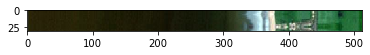

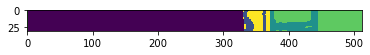

torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)
6


In [82]:
transforms_delete = A.Compose([
        A.PadIfNeeded(32,512),
        A.Resize(32, 512),
        ToTensorV2(),
    ], )
dataset = Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=transforms_delete)

image, mask = dataset[10] # get some sample

#visualize(
#    image=image,
#    mask=mask.squeeze()
#)
#mask = mask.unsqueeze(0)
print(mask.shape)
print(image.shape)
unique, counts = np.unique(mask, return_counts=True)
print(dict(zip(unique, counts)))
print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

plt.imshow(image.permute(1,2,0))
plt.show()

plt.imshow(mask)
plt.show()

#mask = mask.unsqueeze(0)
#print(mask.shape)

print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

print(len(CLASSES))


In [83]:
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [84]:

#Define Loss and Metrics to Monitor (Make sure mode = "multiclass") ======================================
loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'
#Will not monitor any metircs other than loss. 
metrics=[]

# Define Optimizer (Adam in this case) and learning rate ============================
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

In [85]:
# Define training epock =====================================
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

# Define testing epoch =====================================
test_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [86]:
scaler = torch.cuda.amp.GradScaler()

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """TODO: Docstring for train_fn.

    :loader: TODO
    :model: TODO
    :optimizer: TODO
    :loss_fn: TODO
    :scaler: TODO
    :returns: TODO

    """
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE).float()
        targets = targets.to(device=DEVICE)
        targets = targets.unsqueeze(1)
        data = data.permute(0,3,1,2)
        targets = targets.to(torch.int64)

        #print(data.shape)
        #print(targets.shape)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss_values.append(loss.item())
        #run['training/batch/loss'].log(loss)

        #update loop
        loop.set_postfix(loss=loss.item())

for epoch in range(200):
    train_fn(trainDL, model, optimizer, loss, scaler)
    torch.save(model, './best_model.pth')

100%|██████████| 130/130 [00:03<00:00, 35.72it/s, loss=0.0112]


In [87]:
# Predict using saved model
val_transform = A.Compose(
    [A.PadIfNeeded(min_height=32, min_width=512, border_mode=4),A.Resize(32, 512),ToTensorV2()]
)

val_image = Image.open('../../CoastSat/data/blackpool/images/val/tile_0-2820.png')
#val_image.show()

transformed = val_transform(image=np.array(val_image))
image_transformed = transformed['image']
print(image_transformed.shape)

batch_tensor = torch.unsqueeze(image_transformed, 0)
print(batch_tensor.shape)


torch.Size([3, 32, 512])
torch.Size([1, 3, 32, 512])


In [88]:
model = torch.load('./best_model.pth')
model.eval()

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

torch.Size([32, 512])


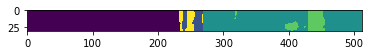

In [89]:
out = model(batch_tensor.to(device=DEVICE).float())

preds = torch.argmax(out, dim=1)
preds = preds.cpu().detach().permute(1,2,0)
preds = preds[:,:,0]

print(preds.shape)

plt.imshow(preds)
plt.show()